# Multiview tripleball extrinsic calibration
Define the tripple ball as below. All balls are line togethor with a short arm and a long arm. The balls are order by arm length. The tripleball has restore the scale, but not know the origin point and XYZ oritation. If you want to know the full world axes, just use `[2A] single ball + [3] worldaxes_register`

The process is just similar to `[2A] single ball`

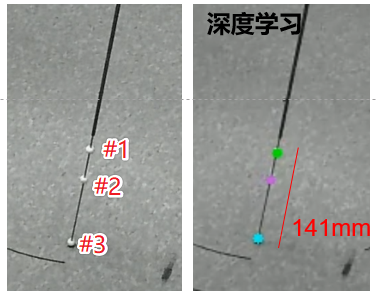 

Pre-request, you have run step1 intrinsic calibration. The `intrinsics_calib_carl.json` is previous outcome.

In [1]:
# import the necessary packages
import pickle
import numpy as np
import json

intrinsics_json = 'intrinsics_calib_carl.json'

## The input ball location data format
The ball position in all view is stored in a `keypoints` variable, which is (NVIEW, NSAMPLE, NKEYPOINT=1, XYP=3).

And the `P` in `XYP` is **0<=P<=1**, means the reliable of this detection. If you failed to detect a ball sometimes in a view, just set the `XY=np.nan`, and `P=0` for **IVIEW**. The `P` will be cutoff around `0.7` to auto delete reliable ball detections.

In [2]:
matfile = 'demo_data/2023-06-02_12-44-39carltripleball.matpkl'
matdata = pickle.load(open(matfile, 'rb'))
assert 'keypoints' in matdata.keys()

print(matdata['keypoints'].shape) #(NVIEW, NSAMPLE, NKEYPOINT=3, xyp=3)
print(matdata['info'])            # The grid video. If you video is not grid. Just keep 'nview', 'fps' is required
print(matdata['views_xywh'])      # (NVIEW, 4) x,y,w,h. If you video is not grid in mycase, you just set x=0,y=0

(9, 4445, 3, 3)
{'vfile': '/mnt/liying.cibr.ac.cn_Data_Temp/multiview_9/chenxf/carl/paper_video/2023-06-02_12-44-39carltripleball.mp4', 'nview': 9, 'fps': 30.0}
[[0, 0, 1280, 800], [1280, 0, 1280, 800], [2560, 0, 1280, 800], [0, 800, 1280, 800], [1280, 800, 1280, 800], [2560, 800, 1280, 800], [0, 1600, 1280, 800], [1280, 1600, 1280, 800], [2560, 1600, 1280, 800]]


## Create a multiview tree
>Similar to 2A_ball_extrinsic_calib

Here is to set the `connectivity` between cameras. Give the hint which pairs of cameras are likely share/(connectivity) most views field of ball. In general case, all cameras share most common view field. You can use default config. 

For example, `0` share with `2`, `0` not with `1`, `1` share with `2`. You can set `"minimal_tree":{[0, 1], [1, 2]}` to global connection.

Note that this `connectivity` define only works when calibration, and won't affect next step 2D<->3D transfrom.


In [3]:
nview=9
minimal_tree = [[i,i+1] for i in range(nview-1)]
setup_dict = {"views": list(range(nview)),
              "minimal_tree": minimal_tree}
setup_json = 'setup.json'
json.dump(setup_dict, open(setup_json, 'w'), indent=4)
print(setup_dict)

{'views': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'minimal_tree': [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8]]}


## Downsample the ball sample to <=1000
It will do
- Downsample ball sample to 1000
- Pack all nessary informtion into one file

In [4]:
from tripleball_matpkl2ballpkl import convert as convert_matpkl2ballpkl

convert_matpkl2ballpkl(matfile, intrinsics_json, setup_json)

python -m lilab.multiview_scripts_dev.s3_ballpkl2calibpkl demo_data/2023-06-02_12-44-39carltripleball.ballpkl


'demo_data/2023-06-02_12-44-39carltripleball.ballpkl'

## Content of `ballpkl`
- **setup**: copy from `setup.json`
- **intrinsics**: copy from `intrinsic_calib.json`
- **landmarks_move_xy**: downsample ball xy position, (NVIEW, 1000, XY)
- **background_img**: (NVIEW, )x(H,W,3) numpy array for background image each view, default not set
- *landmarks_global_xy*, *landmarks_global_cm*, *global_iframe*: obsoleted


In [5]:
ballpklfile = matfile.replace('.matpkl', '.ballpkl')
ballpkl = pickle.load(open(ballpklfile, 'rb'))
print(ballpkl.keys())
print(ballpkl['landmarks_move_xy'].shape)

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics'])
(9, 1000, 2)


## !! The most critical setup
## Multiview extrinsic calibration.
The main precessing is :
1. Pair each two pair cameras in the `setup.json/mini_tree`.
2. Concat all views. Get a rough relative pose.
3. Remove outlier samples. Use bundle ajustment to refine relative poses.

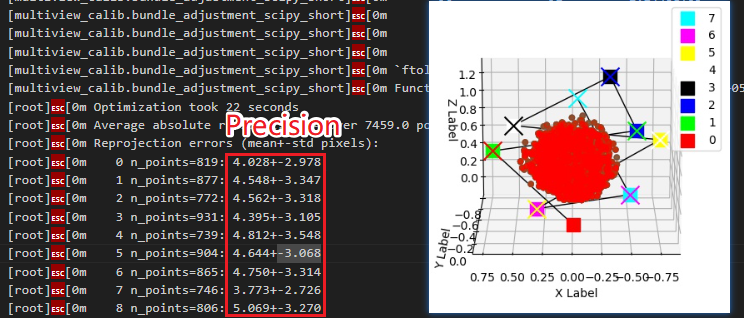

The outcome is `*.calibpkl` file.

In [6]:
from ballpkl2calibpkl import main_calibrate
calibpklfile = main_calibrate(ballpklfile, skip_global=True, skip_camera_intrinsic=True)

2023-06-04 16:08:04,185 [root] -------------------------------------------------
2023-06-04 16:08:04,186 [root] Computing robust relative pose for pair 0->1
2023-06-04 16:08:04,187 [root] Initial relative pose:
2023-06-04 16:08:04,208 [root] Computing relative pose of pair [0, 1]:
2023-06-04 16:08:04,211 [root] 	0 out of 876 points considered outliers.
2023-06-04 16:08:04,218 [root] 	Residual error: 2.196562801772873
2023-06-04 16:08:04,220 [root] 	Sampson distance: 4.071427549867595
2023-06-04 16:08:04,221 [root] Number of additional paths found: 5
2023-06-04 16:08:04,244 [root] 	Computing relative pose of pair [0, 2]:
2023-06-04 16:08:04,246 [root] 		0 out of 967 points considered outliers.
2023-06-04 16:08:04,254 [root] 		Residual error: 1.8477217464223208
2023-06-04 16:08:04,256 [root] 		Sampson distance: 2.3973026706623486
2023-06-04 16:08:04,277 [root] 	Computing relative pose of pair [2, 1]:
2023-06-04 16:08:04,281 [root] 		0 out of 856 points considered outliers.
2023-06-04 16:

Fixing camera instrincis!


100%|██████████| 1000/1000 [00:00<00:00, 23219.39it/s]
2023-06-04 16:08:19,744 [root] The preparation of the input data took: 0.15s
2023-06-04 16:08:19,744 [root] Sizes:
2023-06-04 16:08:19,745 [root] 	 camera_params: (9, 15)
2023-06-04 16:08:19,745 [root] 	 points_3d: (1000, 3)
2023-06-04 16:08:19,746 [root] 	 points_2d: (8488, 2)
2023-06-04 16:08:20,076 [root] Early Outlier rejection:
2023-06-04 16:08:20,078 [root] 	 threshold outliers: 100
2023-06-04 16:08:20,098 [root] 	 Number of points considered outliers: 0
2023-06-04 16:08:20,696 [multiview_calib.bundle_adjustment_scipy_short]    Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality
2023-06-04 16:08:20,697 [multiview_calib.bundle_adjustment_scipy_short]        0              1         4.3011e+05                                    2.03e+09
2023-06-04 16:08:21,189 [multiview_calib.bundle_adjustment_scipy_short]        1              2         5.8013e+04      3.72e+05       1.70e-01       2.03e+07
20

Skipping global BA
python -m lilab.multiview_scripts_dev.s4_matpkl2matcalibpkl  demo_data/2023-06-02_12-44-39carltripleball.matpkl demo_data/2023-06-02_12-44-39carltripleball.calibpkl


## Content of the outcome `calibpkl` file
- **ba_poses**: all intrinsic & extrinsic parameters. `K` (3, 3), `dist`: (K1_K2_T1_T2_K3,), `t` (3,), `R` (3, 3)

In [7]:
calibpkl = pickle.load(open(calibpklfile, 'rb'))
print(calibpkl.keys())

print('ba_poses', calibpkl['ba_poses'])
calibpkl['ba_poses'][0]

dict_keys(['landmarks_global_xy', 'landmarks_move_xy', 'global_iframe', 'landmarks_global_cm', 'background_img', 'setup', 'intrinsics', 'ba_poses'])
ba_poses {0: {'R': [[1.0, 0.0, 0.0], [0.0, 1.0, 3.4113059836805394e-16], [0.0, -3.4113059836805394e-16, 1.0]], 't': [0.0073511085191409345, -0.0020472713612846916, 0.00761884980868557], 'K': [[874.9999029895134, 0.0, 639.9999730416986], [0.0, 875.0000990275362, 400.0000644275753], [0.0, 0.0, 1.0]], 'dist': [-0.005086392858608297, -0.008097959639661695, -9.999548894413292e-05, 7.251129004923851e-06, -9.92557498201032e-05]}, 1: {'R': [[0.15227493920930857, -0.22094170335590566, 0.9633260645321462], [0.6913038770086172, 0.7203948044015835, 0.05594886436791241], [-0.7063365292278576, 0.6574314333140723, 0.26243593116977826]], 't': [-0.663590607241533, -0.06801593233387164, 0.8300939703407101], 'K': [[1136.000062650168, 0.0, 639.9999890491462], [0.0, 1136.0000288078256, 400.0000196162801], [0.0, 0.0, 1.0]], 'dist': [0.050061460818048034, -0.094

{'R': [[1.0, 0.0, 0.0],
  [0.0, 1.0, 3.4113059836805394e-16],
  [0.0, -3.4113059836805394e-16, 1.0]],
 't': [0.0073511085191409345, -0.0020472713612846916, 0.00761884980868557],
 'K': [[874.9999029895134, 0.0, 639.9999730416986],
  [0.0, 875.0000990275362, 400.0000644275753],
  [0.0, 0.0, 1.0]],
 'dist': [-0.005086392858608297,
  -0.008097959639661695,
  -9.999548894413292e-05,
  7.251129004923851e-06,
  -9.92557498201032e-05]}

## Restore scale information
The length between ball1 and ball3 is `141mm` in this case. That's restore this scale in `*.calibpkl`

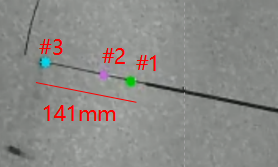

In [8]:
from calibpkl_restore_scale import main as main_rescale
armlen_world = 141.0
recalibpkl = main_rescale(calibpklfile, matfile, armlen_world)

recalibpkl saved as demo_data/2023-06-02_12-44-39carltripleball.recalibpkl


## Next step **[3] world axes registration** and **[4] 2D-3D mutual transformation**.
The **world axes registration** is optional. The tripleball has restore the scale, but not know the origin point and XYZ oritation. If you don't want to do it, just skip it.